# EDA (Exploratory Data Analysis)

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [12]:
train_df = pd.read_csv("../datasets/train.csv")

# Check for missing values
print(train_df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Select Features

- Dropped `PassengerId` and `Ticket` because they likely don’t provide predictive value for the model.  
- Dropped `Cabin` due to a large number of missing values.  
- Kept features that are likely informative: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, and derived `Title` from the Name column.


In [ ]:
# Fill missing values in "Age" with the median for simplicity
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())

# Extract title (e.g., Mr, Mrs, Miss) from "Name" for feature engineering
train_df["Title"] = train_df["Name"].str.extract(r",\s*([^\.]+)\.")

# Group rare or variant titles to reduce category cardinality
train_df["Title"] = (
    train_df["Title"]
    .replace(["Mlle", "Ms"], "Miss")
    .replace(["Mme"], "Mrs")
    .replace(
        ["Lady", "the Countess", "Capt", "Col", "Don", "Dr", 
         "Major", "Rev", "Sir", "Jonkheer", "Dona"],
        "Rare"
    )
)

# Encode "Sex" as numeric (0 = female, 1 = male)
le = LabelEncoder()
train_df["Sex"] = le.fit_transform(train_df["Sex"])

# One-hot encode both "Embarked" and "Title"
train_df = pd.get_dummies(train_df, columns=["Embarked", "Title"], drop_first=True, dtype=int)

# Create FamilySize feature
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1  # +1 for the passenger themselves

# Drop irrelevant features
train_df = train_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])


# Select final features for modeling
X = train_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "FamilySize"] + 
             [col for col in train_df.columns if col.startswith("Embarked_")] + 
             [col for col in train_df.columns if col.startswith("Title_")]].copy()

# Convert to numpy arrays
X = X.values
y = train_df["Survived"].values

### Reveal shape of first examples

In [14]:
# Reveal shape and first few examples
print(f"shapes: \n X -> {X.shape}, y -> {y.shape}")
print(f"\nexamples: \n{X[:5]}")
print(f"\ntargets: \n{y[:5]}")

shapes: 
 X -> (891, 13), y -> (891,)

examples: 
[[ 3.      1.     22.      1.      0.      7.25    2.      0.      1.
   0.      1.      0.      0.    ]
 [ 1.      0.     38.      1.      0.     71.2833  2.      0.      0.
   0.      0.      1.      0.    ]
 [ 3.      0.     26.      0.      0.      7.925   1.      0.      1.
   1.      0.      0.      0.    ]
 [ 1.      0.     35.      1.      0.     53.1     2.      0.      1.
   0.      0.      1.      0.    ]
 [ 3.      1.     35.      0.      0.      8.05    1.      0.      1.
   0.      1.      0.      0.    ]]

targets: 
[0 1 1 1 0]


### Building Intuition
Plotted each feature against survival rate to identify possible trends.

Analysis:
- **Sex and social status** are the strongest survival factors. 
  - Females survived at a rate of ~70%, compared to ~20% for males. 
  - Higher-class passengers (1st class) had significantly better survival chances than 3rd class.
- **Wealth-related features** (`Pclass` and `Fare`) show a clear positive correlation with survival.
- `FamilySize` (`SibSp` + `Parch` + 1) has a non-linear effect: 
  - Survival improves with 1–3 relatives onboard, but drops sharply for large families.


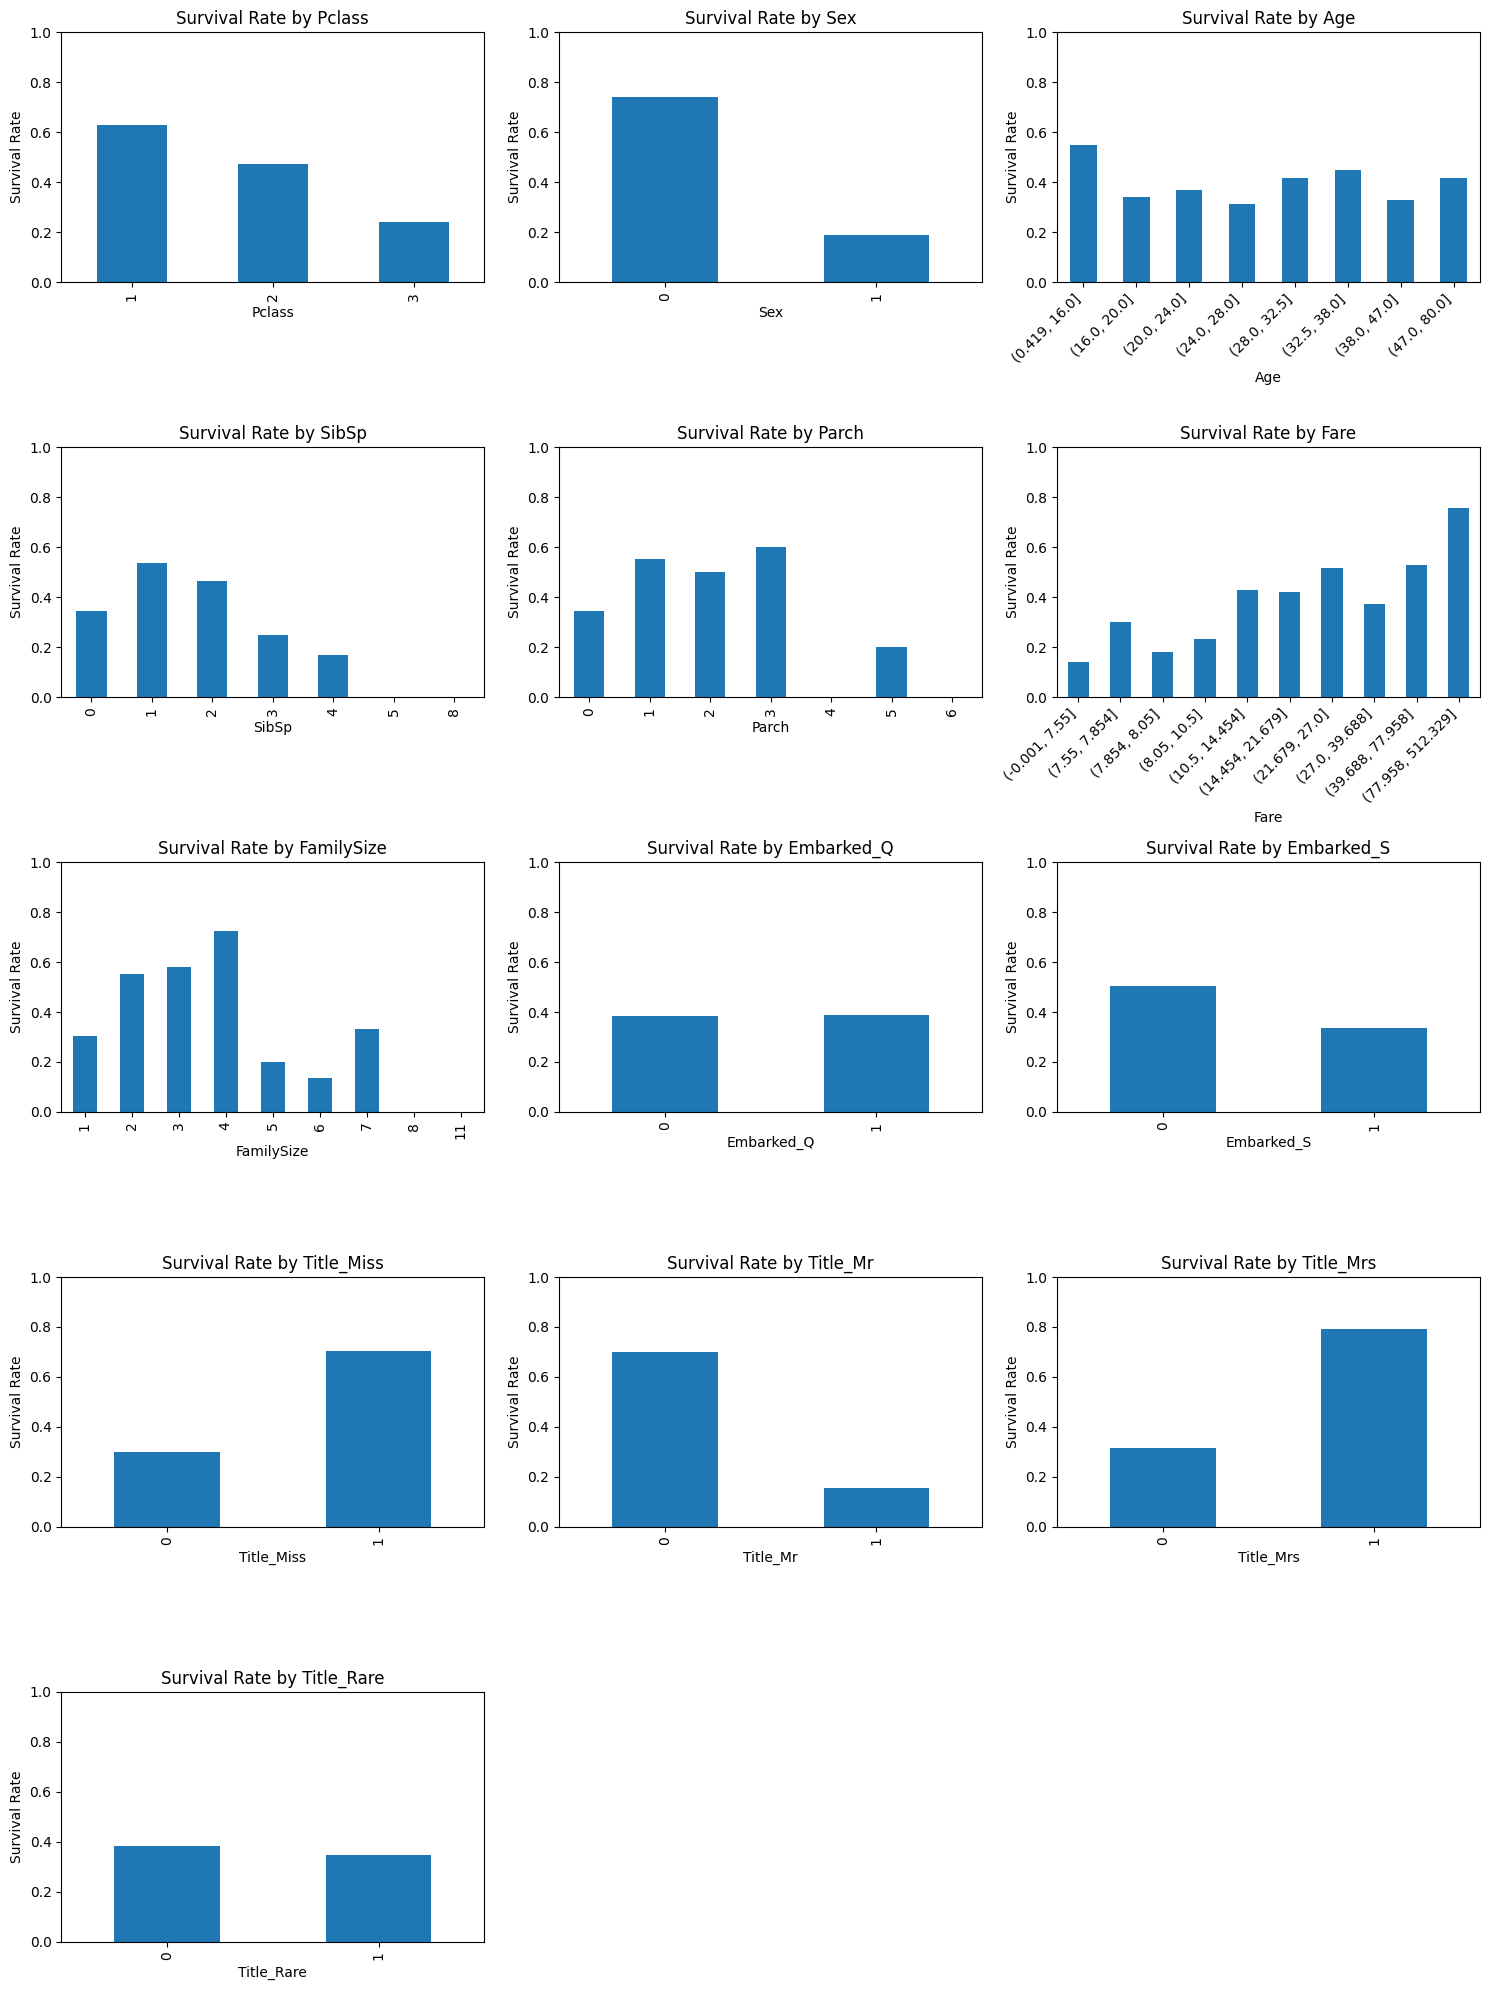

In [15]:
# Plot survival rate by feature
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "FamilySize"] + \
           [col for col in train_df.columns if col.startswith("Embarked_")] + \
           [col for col in train_df.columns if col.startswith("Title_")]

n_features = len(features)
ncols = 3
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    if train_df[feature].nunique() > 10 and pd.api.types.is_numeric_dtype(train_df[feature]):
        # Bin continuous features into quantiles
        binned = pd.qcut(train_df[feature], 10, duplicates="drop")
        survival_rates = train_df.groupby(binned, observed=False)["Survived"].mean()
        survival_rates.plot(kind="bar", ax=ax)
        ax.set_xticklabels([str(interval) for interval in survival_rates.index], rotation=45, ha="right")
    else:
        # Categorical / binary features
        survival_rates = train_df.groupby(feature, observed=False)["Survived"].mean()
        survival_rates.plot(kind="bar", ax=ax)

    ax.set_title(f"Survival Rate by {feature}")
    ax.set_ylabel("Survival Rate")
    ax.set_xlabel(feature)
    ax.set_ylim(0, 1)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Analyze Feature Correlation

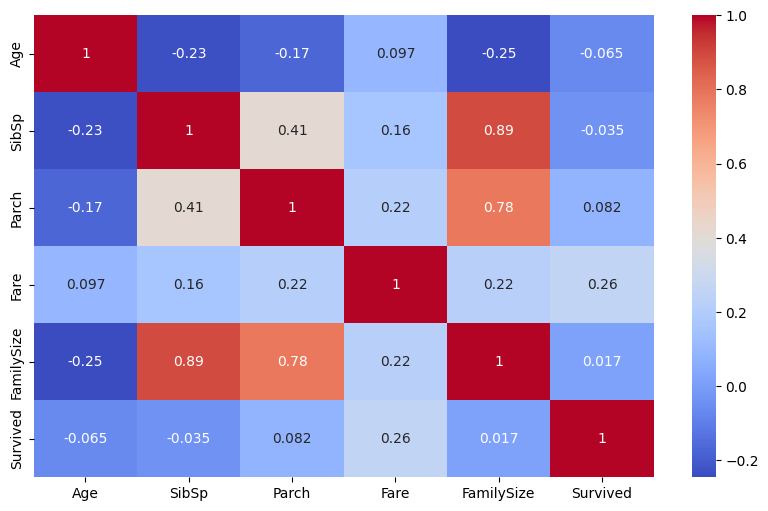

In [16]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(train_df[["Age", "SibSp", "Parch", "Fare", "FamilySize", "Survived"]].corr(), annot=True, cmap="coolwarm")
plt.show()